<a href="https://colab.research.google.com/github/quicksilverri/fanfic-popularuty-prediction/blob/main/fanfic_popularity_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fanfiction popularity prediction 

Articles: 
1. https://mobius-project.eu/predicting-content-popularity-in-fanfiction-communities/
2. https://medium.com/@vkalkunte/what-makes-a-long-fanfic-predicting-word-count-of-fanfiction-from-ao3-c4e468758e56


# Import staff

In [2]:
import requests as req
from bs4 import BeautifulSoup
import pandas as pd 
import seaborn as sns
from time import time, sleep
import matplotlib.pyplot as plt

%matplotlib inline

# Parse the data

In [13]:
marvel_link =  'https://archiveofourown.org/works?commit=Sort+and+Filter&work_search%5Bsort_column%5D=authors_to_sort_on&work_search%5Bother_tag_names%5D=&work_search%5Bexcluded_tag_names%5D=&work_search%5Bcrossover%5D=&work_search%5Bcomplete%5D=&work_search%5Bwords_from%5D=&work_search%5Bwords_to%5D=&work_search%5Bdate_from%5D=&work_search%5Bdate_to%5D=&work_search%5Bquery%5D=&work_search%5Blanguage_id%5D=&tag_id=Marvel'
xmen_link = 'https://archiveofourown.org/works?work_search%5Bsort_column%5D=revised_at&work_search%5Bother_tag_names%5D=&exclude_work_search%5Bfreeform_ids%5D%5B%5D=11175&exclude_work_search%5Bfreeform_ids%5D%5B%5D=263297&work_search%5Bexcluded_tag_names%5D=&work_search%5Bcrossover%5D=&work_search%5Bcomplete%5D=&work_search%5Bwords_from%5D=&work_search%5Bwords_to%5D=&work_search%5Bdate_from%5D=&work_search%5Bdate_to%5D=&work_search%5Bquery%5D=&work_search%5Blanguage_id%5D=&commit=Sort+and+Filter&tag_id=Erik+Lehnsherr*s*Charles+Xavier'
link = marvel_link
pages = 1000

### Create Fanfic class

It's kinda long and simple, so it's hidden. 

In [14]:
def clean(list): 
  """Extracts text from list of bs4.Tags"""

  return [item.get_text() for item in list]

In [15]:
class Fanfic: 
  def __init__(self, fanfic):
    self.fic = fanfic
    self.info = {}

    self.header = self.fic.select('.heading a')
    
    self.get_header()
    self.get_chapters()
    self.get_stats()
    self.get_date()
    self.get_tags()
    self.get_square()

  def get_header(self):
    """Sets title, author nickname and list of fandoms into self.stats dict"""
    
    self.info['title'] = self.header[0].get_text()
    self.info['author'] = self.header[1].get_text()
    self.info['fandoms'] = clean(self.header[2:])

  def get_chapters(self): 
    """Sets number of chapters written and number of chapters intended
    into self.stats dict"""

    def smart_int(n):
      try: 
        return int(n)
      except:
        return None

    chapters = self.fic.select('dd.chapters')[0].get_text()
    written, total = map(smart_int, chapters.split('/'))

    self.info['written'] = written
    self.info['total'] = total

  def get_number(self, selector): 
     """Processes numerical data (removes comma so it can be turned
     into integer)"""

     try: 

       data = self.fic.select(selector)[0].get_text()
       data = int(data.replace(',', ''))
       return data
        
     except: return None

  def get_stats(self): 
     """Sets data collected in Stats section (words, hits, comments,
     bookmarks, collections and language) into self.info dict"""

     self.info['words'] = self.get_number('dd.words')
     self.info['hits'] = self.get_number('dd.hits') 
     self.info['comments'] = self.get_number('dd.comments') 
     self.info['bookmarks'] = self.get_number('dd.bookmarks')
     self.info['collections'] = self.get_number('dd.collections') 
     self.info['lang'] = self.fic.select('dd.language')[0].get_text()
     self.info['kudos'] = self.get_number('.kudos a')

  def get_date(self):  # add date of first publishing??
    """Sets date of the most recent update into self.dict"""

    self.info['date'] = self.fic.select('.datetime')[0].get_text() 
    
  def get_tags(self): 
    """Sets tag-like data into self.info dict"""

    self.info['characters'] = clean(self.fic.select('.characters a.tag'))
    self.info['parings'] = clean(self.fic.select('.relationships a.tag'))
    self.info['freeforms'] = clean(self.fic.select('.freeforms a.tag'))

  def get_square(self): 
    """Sets data from square to the left of fanfic title into self.info dict"""

    self.info['rating'] = self.fic.select('.rating .text')[0].get_text()
    self.info['category'] = clean(self.fic.select('.category .text'))
    self.info['completion'] = self.fic.select('.iswip .text')[0].get_text()
    self.info['warnings'] = clean(self.fic.select('.warnings a.tag'))

  def get_info(self):
     """Return all the data about Fanfic in a DataFrame"""

     df = pd.DataFrame([self.info])

     return df

### Create FanficParser

In [16]:
class FanficParser: 
  def __init__(self, initial_link):
    self.inlink = initial_link
    self.domain = self.get_domain()
    self.df = pd.DataFrame()
    self.link = self.inlink
    self.page = 1

    self.fanfics = []

  def get_domain(self):
     end_of_link = self.inlink.find('/', 8)
     domain = self.inlink[:end_of_link]
     return domain
  
  def parse_page(self): 
    page = req.get(self.link)
    soup = BeautifulSoup(page.content, 'html.parser')
    self.fanfics = soup.select('[role~=article]')

    try: 
      new_link_relative = soup.select('li.next a')[0].get('href')
      self.link = self.domain + new_link_relative

      print(f'{self.page} parsed')
      self.page += 1
    
    except: 
      print('page not parsed, let me wait a sec')
      sleep(20)

  def parse(self, n_pages): 
    start_time = time()
    
    for i in range(n_pages): 
      self.parse_page()
      
      for fanfic in self.fanfics:
        self.df = self.df.append(Fanfic(fanfic).get_info())

    print(f'total {self.df.shape[0]} fanfics')
    self.df.index = range(self.df.shape[0])
    
    end_time = time()
    print(f'time for execution {end_time - start_time}')

  def reset(self):
    self.df = pd.DataFrame()
    self.link = self.inlink
    self.page = 1
    print('Parser resetted')

## Parse info

In [17]:
parser = FanficParser(link)

In [1]:
parser.parse(300)

NameError: ignored

In [21]:
df.to_csv('11640fanfics.csv')

In [20]:
df = parser.df

In [22]:
df.shape

(11640, 20)

# Alternatively: Import the data from csv
I saved 9600 parsed fanfics in a csv so I don't have to parse them each time. 

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/quicksilverri/fanfic-popularuty-prediction/main/9600fanfics.csv', index_col=0)

In [ ]:
df.head()

,title,author,fandoms,written,total,words,hits,comments,bookmarks,collections,lang,kudos,date,characters,parings,freeforms,rating,category,completion,warnings
0,Winter Rose,game of thrones,"['Disney - Fandom', 'Marvel', 'A Song of Ice a...",1,NaN,260,170,1.0,NaN,NaN,English,8.0,07 Sep 2019,"['Hans', 'Elsa', 'Jon Snow', 'Sansa Stark', 'S...","['Hans/Elsa', 'Jon Snow/Sansa Stark', 'Sam/Gil...",['Disney Marvel and Game of Thrones crossover'...,Explicit,['F/M'],Work in Progress,"['Graphic Depictions Of Violence', 'Major Char..."
1,Metal Puppet,The Avengers (Marvel Movies),"['The Avengers (Marvel) - All Media Types', 'W...",1,1.0,288,91,NaN,NaN,NaN,English,8.0,07 Sep 2019,"['James ""Bucky"" Barnes', 'Winter Soldier']",[],"['Poetry', 'Angst', 'Torture', 'Depression']",Teen And Up Audiences,['No category'],Complete Work,['Creator Chose Not To Use Archive Warnings']
2,getting by with some friends,002peach,"['Big Hero 6 (2014)', 'Big Hero 6: The Series ...",2,NaN,5721,205,3.0,6.0,NaN,English,21.0,24 Dec 2019,"['Hiro Hamada', 'Cass Hamada', 'Baymax (Marvel...",[],"['Characters appear in future chapters', 'More...",General Audiences,['Gen'],Work in Progress,"['Creator Chose Not To Use Archive Warnings', ..."
3,the effort made,002peach,"['Big Hero 6 (2014)', 'Big Hero 6: The Series ...",1,1.0,1563,736,3.0,3.0,NaN,English,60.0,25 Dec 2019,"['Karmi (Marvel)', 'Hiro Hamada']",['Hiro Hamada/Karmi'],"['character study of sorts', 'Post S2']",General Audiences,['F/M'],Complete Work,"['Creator Chose Not To Use Archive Warnings', ..."
4,How I Formed the Avengers,003D,"['The Avengers (2012)', 'How I Met Your Mother']",2,NaN,6811,503,2.0,1.0,NaN,English,5.0,08 Feb 2013,"['Steve Rogers', 'Tony Stark', 'Pepper Potts',...","['Pepper Potts/Tony Stark', 'Jane Foster/Thor'...","['Avengers - Freeform', 'How I Met Your Mother...",Not Rated,['Gen'],Work in Progress,['Creator Chose Not To Use Archive Warnings']


# Data preprocessing 
So now we have to figure out what type of data can be suitable for our model. 

1. Replace missing values 
2. Parse dates 
3. Replace categorical values with numbers

In [ ]:
df['comments'] = df['comments'].fillna(0)
df['bookmarks'] = df['bookmarks'].fillna(0)
df['collections'] = df['collections'].fillna(0)
df['kudos'] = df['kudos'].fillna(0)

In [ ]:
# ratings = {
#     'Not Rated': -1,
#     'General Audiences': 0, 
#     'Teen And Up Audiences': 1, 
#     'Mature': 2, 
#     'Explicit': 3, 
# }
# replace_rating = lambda x: ratings[x] if x not in [-1, 0, 1, 2, 3] else x
# df['rating'] = df['rating'].apply(replace_rating)

In [ ]:
# completion = {'Work in Progress': 0, 'Complete Work': 1}
# replace_completion = lambda x: completion[x] if x not in [0, 1] else x
# df['completion'] = df['completion'].apply(replace_completion)

In [ ]:
df['date'] = df['date'].apply(pd.to_datetime)

# Data Cleaning

In [ ]:
df.head(3)

,title,author,fandoms,written,total,words,hits,comments,bookmarks,collections,lang,kudos,date,characters,parings,freeforms,rating,category,completion,warnings
0,Winter Rose,game of thrones,"['Disney - Fandom', 'Marvel', 'A Song of Ice a...",1,NaN,260,170,1.0,0.0,0.0,English,8.0,2019-09-07,"['Hans', 'Elsa', 'Jon Snow', 'Sansa Stark', 'S...","['Hans/Elsa', 'Jon Snow/Sansa Stark', 'Sam/Gil...",['Disney Marvel and Game of Thrones crossover'...,Explicit,['F/M'],Work in Progress,"['Graphic Depictions Of Violence', 'Major Char..."
1,Metal Puppet,The Avengers (Marvel Movies),"['The Avengers (Marvel) - All Media Types', 'W...",1,1.0,288,91,0.0,0.0,0.0,English,8.0,2019-09-07,"['James ""Bucky"" Barnes', 'Winter Soldier']",[],"['Poetry', 'Angst', 'Torture', 'Depression']",Teen And Up Audiences,['No category'],Complete Work,['Creator Chose Not To Use Archive Warnings']
2,getting by with some friends,002peach,"['Big Hero 6 (2014)', 'Big Hero 6: The Series ...",2,NaN,5721,205,3.0,6.0,0.0,English,21.0,2019-12-24,"['Hiro Hamada', 'Cass Hamada', 'Baymax (Marvel...",[],"['Characters appear in future chapters', 'More...",General Audiences,['Gen'],Work in Progress,"['Creator Chose Not To Use Archive Warnings', ..."


In [ ]:
# I don't think that total number of chapters is useful, so we drop it
df.drop('total', axis=1, inplace=True)

In [ ]:
df.sample()

,title,author,fandoms,written,words,hits,comments,bookmarks,collections,lang,kudos,date,characters,parings,freeforms,rating,category,completion,warnings
6286,wishing on city lights,Spider-Man - All Media Types,['Marvel Cinematic Universe'],2,18176,378,9.0,2.0,1.0,English,19.0,2022-06-28,"['Cindy Moon', 'Peter Parker', 'Michelle Jones...","['Michelle Jones/Peter Parker', 'May Parker (S...",['Please check end notes of chapters for used ...,Not Rated,['F/M'],Work in Progress,['No Archive Warnings Apply']


In [ ]:
# In this dataset, it's unlikely that there will be any duplicated, 
# but I'll check just in case 
df.duplicated().unique()

array([False])

In [ ]:
df.describe()

,written,words,hits,comments,bookmarks,collections,kudos
count,9600.000000,9600.000000,9600.000000,9600.000000,9600.000000,9600.000000,9600.000000
mean,2.882708,7113.124583,4087.290521,26.629896,32.723125,0.533229,248.140104
std,7.328651,20506.176438,11367.410618,111.737413,123.508212,0.953301,684.657556
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,998.000000,525.750000,2.000000,2.000000,0.000000,28.000000
50%,1.000000,2180.500000,1364.000000,5.000000,6.000000,0.000000,80.000000
75%,2.000000,5410.000000,3515.500000,17.000000,22.000000,1.000000,217.250000
max,373.000000,832919.000000,456526.000000,4376.000000,6094.000000,28.000000,24526.000000


Fanfics with no words or written characters are redundant. 
Also let's consider fanfic to be a real text only if it has more than 100 words.

Also I think that if a fanfic has only 1 chapter it's considered to be 0 because the number of chapters is not present on the search page. 

In [ ]:
df = df[df.words > 100]

In [ ]:
df.written = df.written.apply(lambda x: 1 if x == 0 else x)

In [ ]:
df.describe()

,written,words,hits,comments,bookmarks,collections,kudos
count,9343.000000,9343.000000,9343.000000,9343.000000,9343.000000,9343.000000,9343.000000
mean,2.931607,7307.959007,4162.931071,27.158835,33.529808,0.526597,253.350316
std,7.421835,20752.185869,11508.481444,113.165549,125.091603,0.958748,692.832163
min,1.000000,102.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1063.500000,538.000000,2.000000,2.000000,0.000000,28.000000
50%,1.000000,2288.000000,1392.000000,6.000000,7.000000,0.000000,83.000000
75%,2.000000,5593.000000,3573.500000,17.000000,23.000000,1.000000,223.000000
max,373.000000,832919.000000,456526.000000,4376.000000,6094.000000,28.000000,24526.000000


Let's invent two new features - words_per_chapter and kudos_per_hit.

*words_per_chapter* shows average length of a chapter in a fanfic;  
*kudos_per_hit* shows what percent of people who read the fanfic - or at least clicked on it - likes the text. 

In [ ]:
df['words_per_chapter'] = df['words'] / df['written']
df['kudos_per_hit'] = df['kudos'] / df['hits']

In [ ]:
df.describe()

,written,words,hits,comments,bookmarks,collections,kudos,words_per_chapter,kudos_per_hit
count,9343.000000,9343.000000,9343.000000,9343.000000,9343.000000,9343.000000,9343.000000,9343.000000,9343.000000
mean,2.931607,7307.959007,4162.931071,27.158835,33.529808,0.526597,253.350316,2623.937472,0.068297
std,7.421835,20752.185869,11508.481444,113.165549,125.091603,0.958748,692.832163,3334.966541,0.046225
min,1.000000,102.000000,1.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000
25%,1.000000,1063.500000,538.000000,2.000000,2.000000,0.000000,28.000000,906.375000,0.036236
50%,1.000000,2288.000000,1392.000000,6.000000,7.000000,0.000000,83.000000,1703.000000,0.060000
75%,2.000000,5593.000000,3573.500000,17.000000,23.000000,1.000000,223.000000,3203.000000,0.091674
max,373.000000,832919.000000,456526.000000,4376.000000,6094.000000,28.000000,24526.000000,67471.000000,1.000000


Having 1 kudo per hit seems quite unnatural, considering that 75th percentile is lower than 0.1. Let's drop everything after 0.975 quantile. 

Lower 0.025 are relateble for out purposes so I won't treat them as outliers.

In [ ]:
df = df[df['kudos_per_hit'] < df['kudos_per_hit'].quantile(0.975)]

In [ ]:
df.describe()

,written,words,hits,comments,bookmarks,collections,kudos,words_per_chapter,kudos_per_hit
count,9108.000000,9108.000000,9108.000000,9108.000000,9108.000000,9108.000000,9108.000000,9108.000000,9108.000000
mean,2.978151,7444.407115,4232.350681,27.224857,33.658652,0.521190,252.600571,2642.788835,0.064529
std,7.510519,20998.819928,11644.178809,114.534845,126.525489,0.964559,699.708938,3366.591176,0.037168
min,1.000000,102.000000,2.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000
25%,1.000000,1070.000000,550.000000,2.000000,2.000000,0.000000,28.000000,910.000000,0.035587
50%,1.000000,2328.000000,1410.000000,5.000000,7.000000,0.000000,82.000000,1718.500000,0.058921
75%,2.000000,5723.250000,3633.750000,16.000000,22.000000,1.000000,219.000000,3213.125000,0.088515
max,373.000000,832919.000000,456526.000000,4376.000000,6094.000000,28.000000,24526.000000,67471.000000,0.167885


In [ ]:
# we get rid of ~500 fanfics, not that bad
df.shape

(9108, 21)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


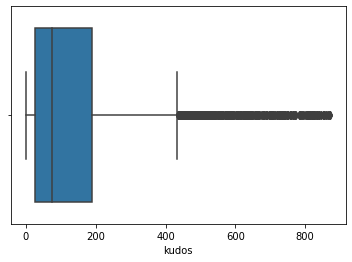

In [ ]:
sns.boxplot(df.kudos[df.kudos < df.kudos.quantile(0.95)])

In [ ]:
s_kudos = df.kudos[df.kudos < df.kudos.quantile(0.95)]

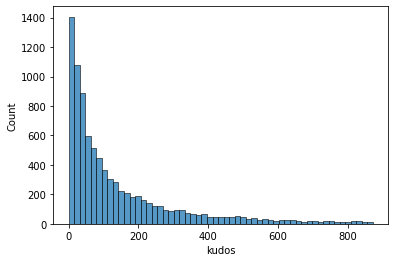

In [ ]:
sns.histplot(s_kudos)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


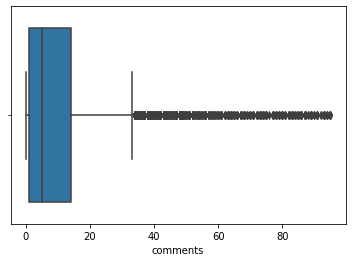

In [ ]:
sns.boxplot(df.comments[df.comments < df.comments.quantile(0.95)])

In [ ]:
df[df.comments == df.comments.max()]

,title,author,fandoms,written,words,hits,comments,bookmarks,collections,lang,...,date,characters,parings,freeforms,rating,category,completion,warnings,words_per_chapter,kudos_per_hit
1783,Safe and (the) Sound,27dragons,"['tisfan', 'Marvel Cinematic Universe', 'The A...",34,84140,92952,4376.0,1009.0,1.0,English,...,2017-07-26,"['Tony Stark', 'James ""Bucky"" Barnes', 'Steve ...","['James ""Bucky"" Barnes/Tony Stark', 'Steve Rog...","['Past Tony Stark/Tiberius Stone', 'Past Bucky...",Explicit,['M/M'],Complete Work,['No Archive Warnings Apply'],2474.705882,0.05235


**HOW TO DEAL WITH LIST VALUES IN PANDAS**: https://towardsdatascience.com/dealing-with-list-values-in-pandas-dataframes-a177e534f173

# Random staff

In [ ]:
df_num = df[['written', 'words', 'hits', 'comments', 'bookmarks', 'collections', 
             'rating', 'kudos', 'completion']]
df_num['words_per_chapter'] = df_num['words'] / df_num['written']
df_num['lang_num'] = df['lang'].apply(lambda x: 1 if x == 'English' else 0)
df_num['kudos_per_hit'] = df['kudos'] / df['hits']

In [ ]:
df_num.describe()

,written,words,hits,comments,bookmarks,collections,rating,kudos,completion,words_per_chapter,lang_num,kudos_per_hit
count,9600.000000,9600.000000,9600.000000,9600.000000,9600.000000,9600.000000,9600.000000,9600.000000,9600.000000,9600.0000,9600.000000,9600.000000
mean,2.882708,7113.124583,4087.290521,26.629896,32.723125,0.533229,1.020938,248.140104,0.827812,inf,0.926771,0.067909
std,7.328651,20506.176438,11367.410618,111.737413,123.508212,0.953301,1.234669,684.657556,0.377563,NaN,0.260526,0.046349
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.0000,0.000000,0.000000
25%,1.000000,998.000000,525.750000,2.000000,2.000000,0.000000,0.000000,28.000000,1.000000,843.7500,1.000000,0.035768
50%,1.000000,2180.500000,1364.000000,5.000000,6.000000,0.000000,1.000000,80.000000,1.000000,1652.9375,1.000000,0.059480
75%,2.000000,5410.000000,3515.500000,17.000000,22.000000,1.000000,2.000000,217.250000,1.000000,3148.2500,1.000000,0.091057
max,373.000000,832919.000000,456526.000000,4376.000000,6094.000000,28.000000,3.000000,24526.000000,1.000000,inf,1.000000,1.000000


In [ ]:
df_corr = df_num.corr()

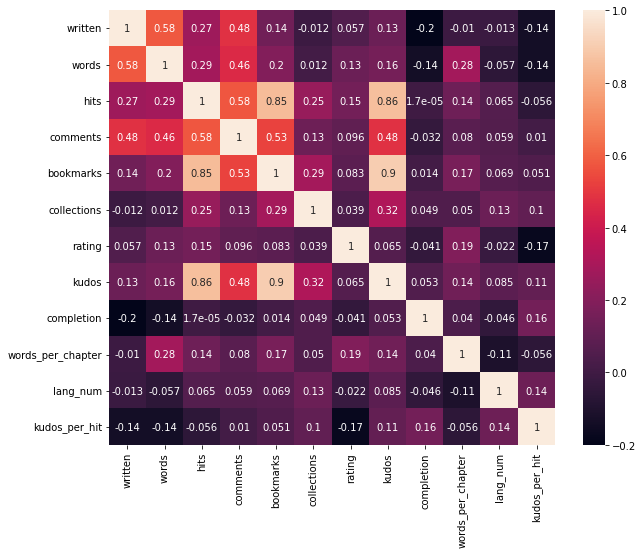

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_corr, annot=True)

# Machine Learning yo

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [ ]:
df_num = df_num[df_num.written > 0]

In [ ]:
y = df_num.kudos

In [ ]:
fanfic_features = ['written', 'words_per_chapter',  
                   'words', 'rating', 'completion', 'lang_num']
              
X = df_num[fanfic_features]

In [ ]:
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)

In [ ]:
fanfic_model = DecisionTreeRegressor(random_state=1)

In [ ]:
fanfic_model.fit(train_X, train_y)

DecisionTreeRegressor(random_state=1)

In [ ]:
val_predictions = fanfic_model.predict(val_X)

In [ ]:
val_predictions

array([177.,  38.,  34., ...,  45., 276.,   3.])

In [ ]:
mean_absolute_error(val_y, val_predictions)

336.54360019449155

In [ ]:
y_comparison = pd.DataFrame()
y_comparison['actual'] = val_y
y_comparison['predicted'] = val_predictions

In [ ]:
y_comparison

,actual,predicted
0,254,72.0
1544,53,381.0
5989,32,374.0
0,233,125.0
307,221,115.0
...,...,...
0,99,144.0
17,135,32.0
4613,41,175.0
1993,263,224.0
